<a href="https://colab.research.google.com/github/DaviCampos09/sistema_recomendacao/blob/main/sistema_de_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.applications.resnet50 import preprocess_input # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense # type: ignore
from tensorflow.keras.models import Model # type: ignore

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Configuracoes
DATASET_PATH = '/content/drive/MyDrive/Datasets/Objects' #Defina o caminho para o diretório onde estão armazenados os dados do dataset.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
MODEL_SAVE_PATH = '/content/drive/MyDrive/Datasets/Objects/resnet50_model.h5' #Especifique o caminho onde o modelo treinado será salvo.
os.makedirs('/content/drive/MyDrive/Datasets/Objects/', exist_ok=True)

In [20]:
# Função que lê as coordenadas dos bounding boxes a partir dos arquivos de rótulos.
def read_bounding_boxes(label_dir):
    bounding_boxes = {}
    for class_dir in os.listdir(label_dir):
        class_path = os.path.join(label_dir, class_dir, 'Label')
        if os.path.isdir(class_path):
            for label_file in os.listdir(class_path):
                file_path = os.path.join(class_path, label_file)
                with open(file_path, 'r') as f:
                    boxes = []
                    for line in f:
                        parts = line.strip().split()
                        # Verifica se há pelo menos 5 elementos (nome da classe + 4 coordenadas)
                        if len(parts) >= 5:
                            # Ignora o nome da classe e converte as coordenadas em inteiros
                            coordinates = list(map(float, parts[1:]))
                            boxes.append(coordinates)
                    bounding_boxes[label_file] = boxes
    return bounding_boxes

In [21]:
#Função que prepara as imagens para o treinamento ou validação, aplicando pré-processamento necessário.
def preprocess_images(image_dir, image_size, bounding_boxes):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    return generator, bounding_boxes

In [22]:
#Função principal para construir e treinar o modelo ResNet50 com os dados fornecidos.
def build_and_train_model(train_gen, val_gen, save_path):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        steps_per_epoch=train_gen.samples // BATCH_SIZE,
        validation_steps=val_gen.samples // BATCH_SIZE
    )

    model.save(save_path)
    return model

In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset in Google Drive
base_dir = '/content/drive/MyDrive/Datasets/Objects'

# List of class folders
class_folders = ['bikes', 'shirts', 'shoes', 'watches']

# Create train and validation directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Split ratio (e.g., 80% train, 20% validation)
split_ratio = 0.8

# Loop through each class and split the images
for class_name in class_folders:
    class_dir = os.path.join(base_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    train_images, val_images = train_test_split(images, train_size=split_ratio, random_state=42)

    # Create class directories in train and validation folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

    # Copy images to train directory
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

    # Copy images to validation directory
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(validation_dir, class_name, img))

print("Train and validation directories created successfully!")

Train and validation directories created successfully!


In [25]:
if __name__ == '__main__':
    label_dir = DATASET_PATH
    bounding_boxes = read_bounding_boxes(label_dir)
    train_generator, bounding_boxes = preprocess_images(DATASET_PATH + '/train/', IMAGE_SIZE, bounding_boxes)
    val_generator, _ = preprocess_images(DATASET_PATH + '/validation/', IMAGE_SIZE, bounding_boxes)

    # Treinamento do Modelo
    build_and_train_model(train_generator, val_generator, MODEL_SAVE_PATH)

Found 444 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8013 - loss: 0.6564 - val_accuracy: 1.0000 - val_loss: 2.9533e-05
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 3.5062e-05

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 3.5062e-05 - val_accuracy: 1.0000 - val_loss: 1.3535e-07
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 9.8364e-06 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step - accuracy: 1.0000 - loss: 2.3742e-05 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 1.0000 - loss: 3.8008e-06 - val_accuracy: 1.0000 - val_loss: 6.5684e-04
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.7693e-07 - val_accuracy: 1.0000 - val_loss: 9.7724e-07
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 1.0000 - loss: 4.3362

In [26]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.applications.resnet50 import preprocess_input # type: ignore
import matplotlib.pyplot as plt
import heapq  # Para obter os 'top_n' itens mais próximos de forma eficiente

In [35]:
# Configuracoes
DATASET_PATH = '/content/drive/MyDrive/Datasets/Objects'
IMAGE_SIZE = (224, 224)
MODEL_SAVE_PATH = '/content/drive/MyDrive/Datasets/Objects/resnet50_model.h5'
QUERY_IMAGES = {
    'bicicleta': '/content/drive/MyDrive/Datasets/Objects/train/bikes/Bike10.jpg',
    'camiseta': '/content/drive/MyDrive/Datasets/Objects/train/shirts/778.jpg',
    'sapato': '/content/drive/MyDrive/Datasets/Objects/train/shoes/101.jpg',
    'relógio': '/content/drive/MyDrive/Datasets/Objects/train/watches/1.jpg'
}

In [28]:
# Configurar a GPU para ser usada
def configure_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Limitar a memória usada pela GPU (opcional)
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])  # 8GB de memória
        except RuntimeError as e:
            print(e)

In [29]:
# Carrega o modelo previamente treinado a partir do caminho especificado.
def load_model(save_path):
    return tf.keras.models.load_model(save_path)

In [30]:
def generate_embeddings(model, image):  # Gera embeddings de características para uma imagem usando o modelo fornecido.
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
    image = cv2.resize(image, IMAGE_SIZE)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Calcular o embedding utilizando a GPU se disponível
    with tf.device('/GPU:0'):  # Usando a primeira GPU (se disponível)
        return feature_extractor.predict(image)[0]

In [39]:
import heapq
import numpy as np
import os
import cv2

def recommend_similar_items(model, query_image, dataset_path, top_n=10, max_images_per_class=5):
    query_embedding = generate_embeddings(model, query_image)
    similarities = []

    # Filter to only consider directories within the dataset path
    for class_dir in [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]:
        class_path = os.path.join(dataset_path, class_dir)
        image_count = 0  # Reinicia o contador para cada classe

        for img_file in os.listdir(class_path):
            if img_file.endswith('.jpg') or img_file.endswith('.png'):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Erro ao carregar a imagem: {img_path}")
                    continue

                img_embedding = generate_embeddings(model, img)
                similarity = np.linalg.norm(query_embedding - img_embedding)

                if len(similarities) < top_n:
                    heapq.heappush(similarities, (-similarity, img_path))
                else:
                    heapq.heappushpop(similarities, (-similarity, img_path))

                image_count += 1
                if image_count >= max_images_per_class:
                    break  # Sai do loop desta classe

    similarities.sort(key=lambda x: x[0])
    return [(img_path, -similarity) for similarity, img_path in similarities]


In [32]:
# Plota a imagem de consulta e os resultados recomendados para visualização.
def plot_results(query_image_path, results):
    query_image = cv2.imread(query_image_path)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(results) + 1, 1)
    plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.title('Query Image')

    for i, (result_path, _) in enumerate(results):
        img = cv2.imread(result_path)
        plt.subplot(1, len(results) + 1, i + 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Result {i + 1}')

    plt.show()


Resultados para a classe: bicicleta
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

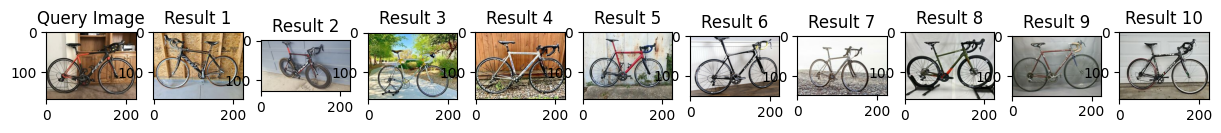

Resultados para a classe: camiseta
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 393s 393s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
if __name__ == '__main__':
    # Carregamento do modelo
    model = load_model(MODEL_SAVE_PATH)

    # Recomendacao e visualizacao para cada classe
    for class_name, query_image_path in QUERY_IMAGES.items():
        print(f'Resultados para a classe: {class_name}')
        query_image = cv2.imread(query_image_path)
        results = recommend_similar_items(model, query_image, DATASET_PATH, top_n=10, max_images_per_class=10)  # Limitar a 10 itens
        plot_results(query_image_path, results)